In [44]:
!pip install -q pandas seaborn statsmodels

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.display import clear_output

### Boosted Trees 모델을 로컬 및 글로벌로 해석하는 방법

로컬 해석 가능성은 개별 예제 수준에서 모델의 예측을 이해하는 것을 의미하고 글로벌 해석 가능성은 모델 전체를 이해하는 것을 의미합니다. 이러한 기술은 머신 러닝(ML) 실무자가 모델 개발 단계에서 편향과 버그를 감지하는 데 도움이 될 수 있습니다.

로컬 해석을 위해 인스턴스 별 기여도를 만들고 시각화하는 방법을 배웁니다. 이를 기능 중요도와 구별하기 위해 이러한 값을 방향성 기능 기여 (DFC) 라고 합니다.

In [3]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [4]:
import tensorflow as tf
tf.random.set_seed(123)

In [5]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
    return fc.indicator_column(
        fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    # Need to one-hot encode categorical features.
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

In [6]:
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
            
        dataset = dataset.repeat(n_epochs).batch(NUM_EXAMPLES)
        return dataset
    return input_fn

In [7]:
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [8]:
params = {
    'n_trees': 50,
    'max_depth': 3,
    'n_batches_per_layer': 1,
    'center_bias': True # DFC를 얻으려면 center_bias = True 해야합니다. 기능을 사용하기 전에 모델이 초기
}                       # 예측을 수행하게 됩니다.

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
est.train(train_input_fn, max_steps=100)

results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.803030
accuracy_baseline,0.625000
auc,0.869483
auc_precision_recall,0.851343
average_loss,0.416908
label/mean,0.375000
loss,0.416908
precision,0.752688
prediction/mean,0.386508
recall,0.707071


성능상의 이유로 데이터가 메모리에 맞을 때 ```boosted_trees_classifier_train_in_memory``` 함수를 사용하는 것이 좋습니다. 그러나 훈련 시간이 문제가되지 않거나 매우 큰 데이터 세트가 있고 분산 훈련을 원하는 경우 위에 표시된 ```tf.estimator.BoostedTrees``` API를 사용하십시오.

이 방법을 사용할 때는 전체 데이터 세트에서 작동하므로 입력 데이터를 일괄 처리하면 안됩니다.

In [9]:
in_memory_params = dict(params)
in_memory_params['n_batches_per_layer'] = 1
# In-memory input_fn does not use batching.
def make_inmemory_train_input_fn(X, y):
    Y = np.expand_dims(y, axis=1)
    def input_fn():
        return dict(X), y
    return input_fn

train_input_fn = make_inmemory_train_input_fn(dftrain, y_train)

est = tf.estimator.BoostedTreesClassifier(
    feature_columns,
    train_in_memory=True,
    **in_memory_params
)

est.train(train_input_fn)
print(est.evaluate(eval_input_fn))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpdnd3lgkb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns_colors = sns.color_palette('colorblind')

### 로컬 해석 가능성

다음으로 DFC (방향 기능 기여도)를 출력합니다. DFC는 예측에 많이 사용된 기능들을 감지하며 그 기능들이 증가하거나 감소되었을 때 확률이 어떻게 바뀔지도 보여줍니다.

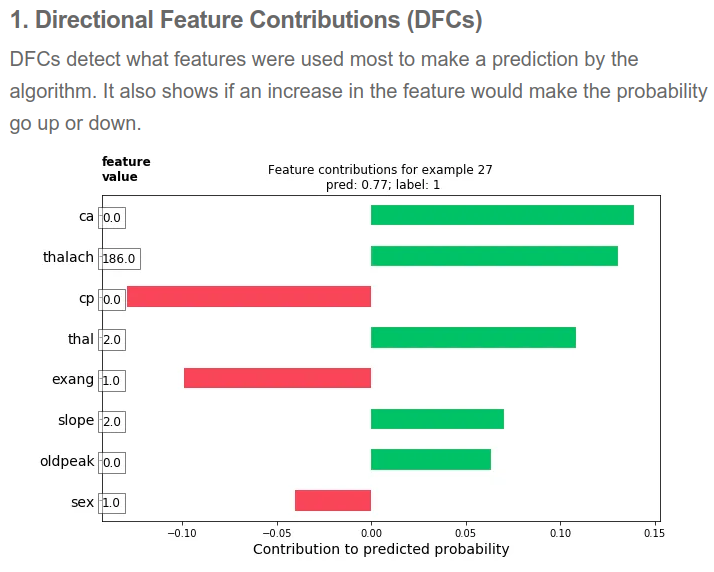

In [19]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpdnd3lgkb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tm

In [21]:
len(pred_dicts), pred_dicts

(264,
 [{'logits': array([-1.9543839], dtype=float32),
   'logistic': array([0.12407612], dtype=float32),
   'probabilities': array([0.8759239 , 0.12407612], dtype=float32),
   'class_ids': array([0]),
   'classes': array([b'0'], dtype=object),
   'all_class_ids': array([0, 1], dtype=int32),
   'all_classes': array([b'0', b'1'], dtype=object),
   'bias': 0.38755981720511457,
   'dfc': OrderedDict([('age', -0.07637449785349863),
                ('sex', -0.07462799762152464),
                ('class', -0.043060319471033476),
                ('deck', -0.04292398827928487),
                ('embark_town', -0.017429274157995667),
                ('fare', -0.01315613505150856),
                ('n_siblings_spouses', 0.003336956561650062),
                ('parch', 0.0007515688683490396),
                ('alone', 0.0)])},
  {'logits': array([-0.47279555], dtype=float32),
   'logistic': array([0.38395482], dtype=float32),
   'probabilities': array([0.61604524, 0.3839548 ], dtype=float32),
   

In [22]:
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
age,264.0,-0.025980,0.093778,-0.147969,-0.077102,-0.054172,0.004607,0.505813
sex,264.0,0.006559,0.107806,-0.097792,-0.074628,-0.072858,0.138226,0.182456
class,264.0,0.016631,0.093784,-0.162675,-0.043060,-0.041724,0.033055,0.226018
deck,264.0,-0.018093,0.032575,-0.094638,-0.042912,-0.032754,0.001897,0.199893
embark_town,264.0,-0.007017,0.031436,-0.056042,-0.017526,-0.015517,-0.003948,0.086491
fare,264.0,0.027026,0.089513,-0.224306,-0.028076,-0.002334,0.072627,0.285098
n_siblings_spouses,264.0,0.001434,0.025849,-0.133110,0.002419,0.003337,0.006167,0.103482
parch,264.0,0.000019,0.011432,-0.098722,0.000654,0.000864,0.001482,0.040270
alone,264.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
df_dfc.head(3)

,age,sex,class,deck,embark_town,fare,n_siblings_spouses,parch,alone
0,-0.076374,-0.074628,-0.043060,-0.042924,-0.017429,-0.013156,0.003337,0.000752,0.0
1,0.022458,-0.089903,0.033830,0.045346,-0.011928,-0.016868,0.012023,0.001438,0.0
2,-0.038841,0.149573,0.226018,-0.094638,-0.005581,0.177588,0.006417,0.000729,0.0


DFC의 좋은 특성은 기여도의 합과 편향이 주어진 예에 대한 예측과 같다는 것입니다.

Sum of DFCs of bias == probabality

In [27]:
# Raises an AssertionError if two items are not eqaul up to desired precision.
np.testing.assert_almost_equal??

In [28]:
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values, probs.values)

In [34]:
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot"""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
                fontproperties=font, size=12)

def plot_example(example):
    TOP_N = 8
    sorted_ix = example.abs().sort_values()[-TOP_N:].index
    example = example[sorted_ix]
    colors = example.map(_get_color).tolist()
    ax = example.to_frame().plot(kind='barh',
                                color=[colors],
                                legend=None,
                                alpha=0.75,
                                figsize=(10,6))
    ax.grid(False, axis='y')
    ax.set_yticklabels(ax.get_yticklabels(), size=14)
    
    _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
    return ax

In [35]:
df_dfc.iloc[182]

age                  -0.071202
sex                  -0.074855
class                -0.048776
deck                 -0.042893
embark_town          -0.017793
fare                  0.034820
n_siblings_spouses    0.000107
parch                 0.000801
alone                 0.000000
Name: 182, dtype: float64

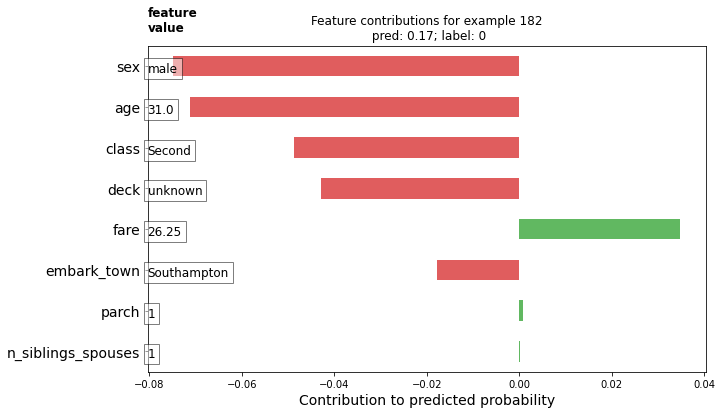

In [36]:
# Plot results.
ID = 182
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

더 큰 기여도는 모델의 예측에 더 큰 영향을 미칩니다. 음수 기여는이 주어진 예제의 특징 값이 모델의 예측을 감소 시켰음을 나타내며 양수 값은 예측 증가에 기여합니다.

또한 voilin 플롯을 사용하여 전체 분포와 비교하여 예제의 DFC를 플롯 할 수 있습니다.

In [37]:
# Boilerplate plotting code.
def dist_violin_plot(df_dfc, ID):
    # Initialize plot.
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Create example dataframe.
    TOP_N = 8  # View top 8 features.
    example = df_dfc.iloc[ID]
    ix = example.abs().sort_values()[-TOP_N:].index
    example = example[ix]
    example_df = example.to_frame(name='dfc')

    # Add contributions of entire distribution.
    parts=ax.violinplot([df_dfc[w] for w in ix],
                 vert=False,
                 showextrema=False,
                 widths=0.7,
                 positions=np.arange(len(ix)))
    face_color = sns_colors[0]
    alpha = 0.15
    for pc in parts['bodies']:
        pc.set_facecolor(face_color)
        pc.set_alpha(alpha)

    # Add feature values.
    _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

    # Add local contributions.
    ax.scatter(example,
              np.arange(example.shape[0]),
              color=sns.color_palette()[2],
              s=100,
              marker="s",
              label='contributions for example')

    # Legend
    # Proxy plot, to show violinplot dist on legend.
    ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
          color=face_color, alpha=alpha, linewidth=10)
    legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large',
                     frameon=True)
    legend.get_frame().set_facecolor('white')

    # Format plot.
    ax.set_yticks(np.arange(example.shape[0]))
    ax.set_yticklabels(example.index)
    ax.grid(False, axis='y')
    ax.set_xlabel('Contribution to predicted probability', size=14)

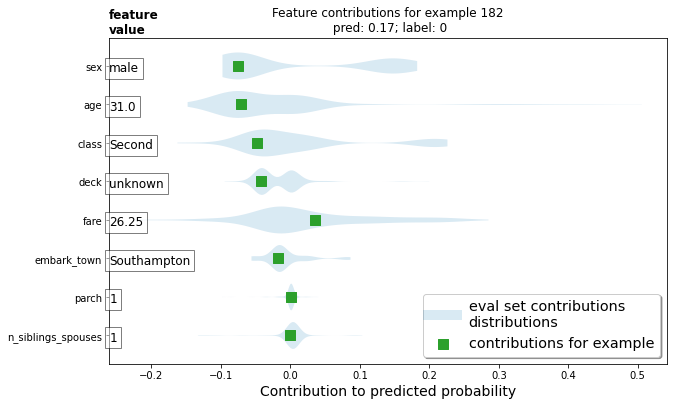

In [38]:
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
plt.show()

### 글로벌 기능의 중요성

또한 개별 예측을 연구하는 대신 모델 전체를 이해하고 싶을 수 있습니다. 아래에서 다음을 계산하고 사용합니다.

- ```est.experimental_feature_importances``` 사용한 이득 기반 기능 중요성
- 순열 특성 중요성
- ```est.experimental_predict_with_explanations``` 사용하여 DFC 집계

이득 기반 기능 중요도는 특정 기능으로 분할 할 때 손실 변화를 측정하는 반면 순열 기능 중요도는 각 기능을 하나씩 셔플하고 모델 성능의 변화를 셔플 된 기능에 기여하여 평가 세트에서 모델 성능을 평가하여 계산됩니다.

일반적으로 순열 특성 중요도는 이득 기반 중요도보다 선호되지만, ...

In [39]:
est.experimental_feature_importances??

In [42]:
df_imp

sex                   3.860494e-01
fare                  1.983201e-01
class                 1.419968e-01
age                   1.315090e-01
deck                  5.722813e-02
embark_town           4.512859e-02
n_siblings_spouses    2.902454e-02
parch                 1.074328e-02
alone                 1.626306e-07
dtype: float64

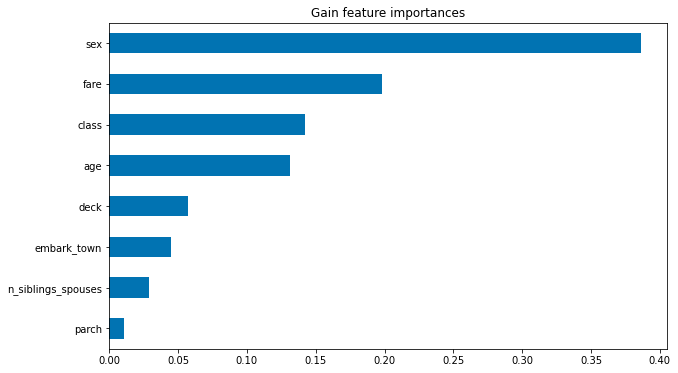

In [40]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

N = 8
ax = (df_imp.iloc[0:N][::-1].
      plot(kind='barh',
           color=sns_colors[0],
           title="Gain feature importances",
           figsize=(10, 6)))
ax.grid(False, axis='y')

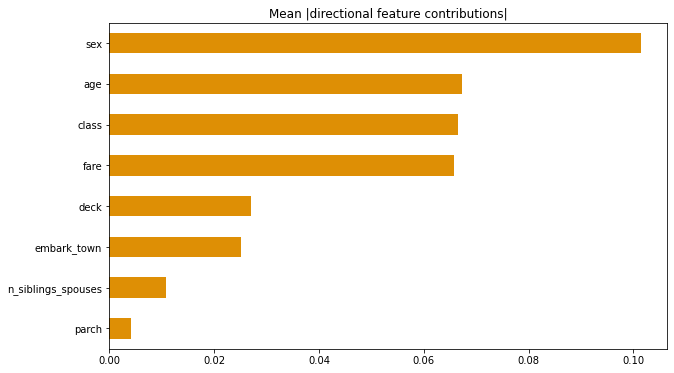

In [41]:
# Plot.
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index  # Average and sort by absolute.
ax = dfc_mean[sorted_ix].plot(kind='barh',
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')

In [46]:
feature

0.0000     -0.112247
0.0000     -0.046891
0.0000     -0.111268
4.0125     -0.088005
6.4500     -0.046051
              ...   
151.5500   -0.066028
151.5500    0.181000
211.3375    0.204456
227.5250    0.152909
263.0000    0.172408
Length: 264, dtype: float64

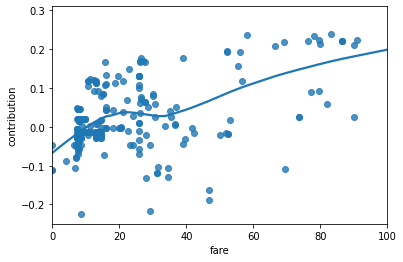

In [49]:
FEATURE = 'fare'
feature = pd.Series(df_dfc[FEATURE].values, index=dfeval[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True)
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE)
ax.set_xlim(0, 100)
plt.show()

In [50]:
sns.regplot??

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-30T20:08:15Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdnd3lgkb/model.ckpt-153
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.34796s
INFO:tensorflow:Finished evaluation at 2020-08-30-20:08:15
INFO:tensorflow:Saving dict for global step 153: accuracy = 0.81439394, accuracy_baseline = 0.625, auc = 0.86853385, auc_precision_recall = 0.8522887, average_loss = 0.4158357, global_step = 153, label/mean = 0.375, loss = 0.4158357, precision = 0.7604167, prediction/mean = 0.38813925, recall = 0.7373737
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 153: /tmp/tmpdnd3lgkb/model.ckpt-153
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-30T20:08:15Z
INFO:tensorflow:Graph was final

INFO:tensorflow:Finished evaluation at 2020-08-30-20:08:20
INFO:tensorflow:Saving dict for global step 153: accuracy = 0.81439394, accuracy_baseline = 0.625, auc = 0.86853385, auc_precision_recall = 0.8522887, average_loss = 0.4158357, global_step = 153, label/mean = 0.375, loss = 0.4158357, precision = 0.7604167, prediction/mean = 0.38813925, recall = 0.7373737
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 153: /tmp/tmpdnd3lgkb/model.ckpt-153
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-30T20:08:21Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdnd3lgkb/model.ckpt-153
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.30958s
INFO:tensorflow:Finished evaluation at 2020-08-30-20:08:21
INFO:tensorflow:Saving dict for global step 153: accuracy = 0.75757575, accuracy_baseline = 0.625, auc = 

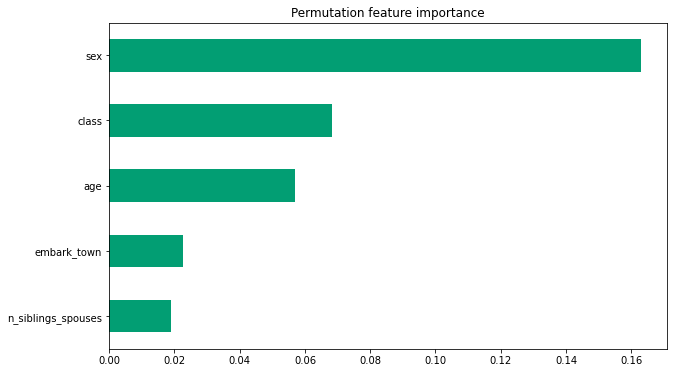

In [51]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    """TensorFlow estimator accuracy."""
    eval_input_fn = make_input_fn(X,
                                  y=y,
                                  shuffle=False,
                                  n_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']

features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
importances = permutation_importances(est, dfeval, y_eval, accuracy_metric,
                                      features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')
plt.show()

In [53]:
df_imp

sex                   0.162879
n_siblings_spouses    0.018939
parch                -0.003788
class                 0.068182
deck                  0.003788
embark_town           0.022727
alone                 0.000000
age                   0.056818
fare                  0.000000
dtype: float32

### 모델 피팅 시각화

먼저 다음 공식을 사용하여 훈련 데이터를 시뮬레이션 / 생성합니다.

z = x * e ^ (-x^2 -y^2)

여기서 (z)는 예측하려는 종속 변수이고 (x) 및 (y)는 특성입니다.

In [54]:
from numpy.random import uniform, seed
from scipy.interpolate import griddata

# Create fake data
seed(0)
npts = 5000
x = uniform(-2, 2, npts)
y = uniform(-2, 2, npts)
z = x*np.exp(-x**2 - y**2)
xy = np.zeros((2, np.size(x)))
xy[0] = x
xy[1] = y
xy = xy.T

In [55]:
print(xy.shape, z.shape)

(5000, 2) (5000,)


In [59]:
xi = np.linspace(-2.0, 2.0, 3)
yi = np.linspace(-2.1, 2.1, 5)
print(xi, yi)
xi, yi = np.meshgrid(xi, yi)
print(xi, yi)

[-2.  0.  2.] [-2.1  -1.05  0.    1.05  2.1 ]
[[-2.  0.  2.]
 [-2.  0.  2.]
 [-2.  0.  2.]
 [-2.  0.  2.]
 [-2.  0.  2.]] [[-2.1  -2.1  -2.1 ]
 [-1.05 -1.05 -1.05]
 [ 0.    0.    0.  ]
 [ 1.05  1.05  1.05]
 [ 2.1   2.1   2.1 ]]


In [64]:
df = pd.DataFrame({'x': x, 'y': y, 'z': z})

xi = np.linspace(-2.0, 2.0, 200)
yi = np.linspace(-2.1, 2.1, 210)
xi, yi = np.meshgrid(xi, yi)

df_predict = pd.DataFrame({
    'x': xi.flatten(),
    'y': yi.flatten()
})
predict_shape = xi.shape

In [73]:
def plot_contour(x, y, z, **kwargs):
    # Grid the data.
    plt.figure(figsize=(10, 8))
    # Contour the gridded data, plotting dots at the nonuniform data points.
    CS = plt.contour(x, y, z, 15, linewidths=0.5, colors='k') # draw lines
    CS = plt.contourf(x, y, z, 15, vmax=abs(zi).max(), vmin=-abs(zi).max(), cmap='RdBu_r') # fill colors
    plt.colorbar()  # Draw colorbar.
    # Plot data points.
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)

In [75]:
griddata??  # Interpolate unstructured D-dimensional data.

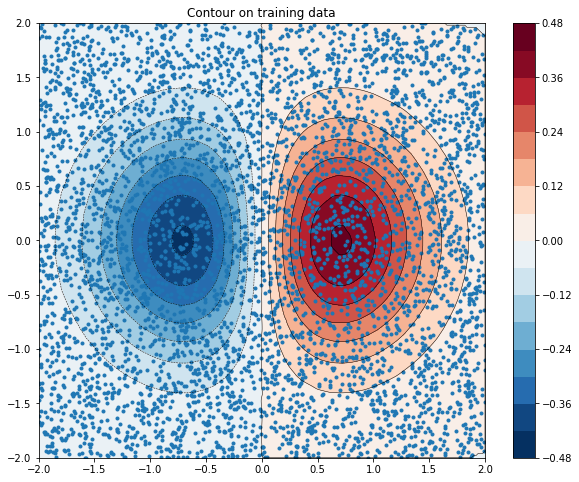

In [74]:
zi = griddata(xy, z, (xi, yi), method='linear', fill_value='0')
plot_contour(xi, yi, zi)
plt.scatter(df.x, df.y, marker='.')
plt.title("Contour on training data")
plt.show()

In [76]:
fc = [tf.feature_column.numeric_column('x'),
      tf.feature_column.numeric_column('y')]

In [78]:
df_predict.head()

,x,y
0,-2.000000,-2.1
1,-1.979899,-2.1
2,-1.959799,-2.1
3,-1.939698,-2.1
4,-1.919598,-2.1


In [79]:
def predict(est):
    """Predictions from a given estimator."""
    predict_input_fn = lambda: tf.data.Dataset.from_tensors(dict(df_predict))
    preds = np.array([p['predictions'][0] for p in est.predict(predict_input_fn)])
    return preds.reshape(predict_shape)

In [80]:
train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(fc)
est.train(train_input_fn, max_steps=500);

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpb_o9iyix', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructio

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpb_o9iyix/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


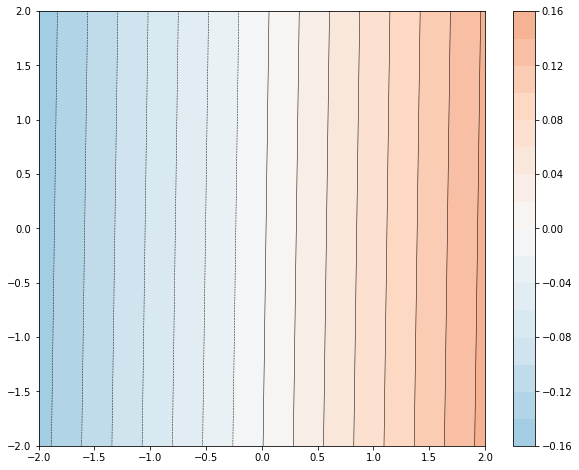

In [81]:
plot_contour(xi, yi, predict(est))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphjebwbcz/model.ckpt-222
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


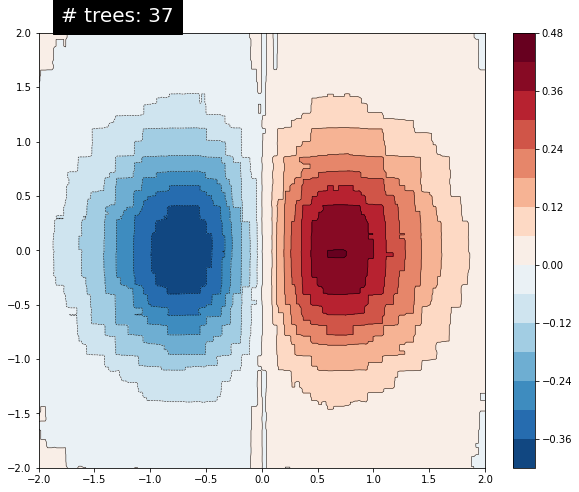

In [82]:
n_trees = 37 

est = tf.estimator.BoostedTreesRegressor(fc, n_batches_per_layer=1, n_trees=n_trees)
est.train(train_input_fn, max_steps=500)
clear_output()
plot_contour(xi, yi, predict(est))
plt.text(-1.8, 2.1, '# trees: {}'.format(n_trees), color='w', backgroundcolor='black', size=20)
plt.show()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmprvvbnv0t/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


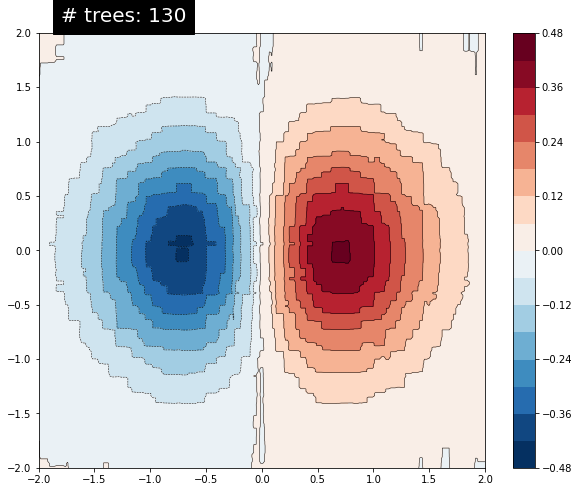

In [83]:
n_trees = 130

est = tf.estimator.BoostedTreesRegressor(fc, n_batches_per_layer=1, n_trees=n_trees)
est.train(train_input_fn, max_steps=500)
clear_output()
plot_contour(xi, yi, predict(est))
plt.text(-1.8, 2.1, '# trees: {}'.format(n_trees), color='w', backgroundcolor='black', size=20)
plt.show()